# Vehicle Detection and Tracking

The goal of this project is to write a software pipeline to identify vehicles in a video from a front facing camera on a car

### Import packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import glob
import time
import random
import pickle
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from collections import deque

%matplotlib inline

### Load and Visualize the Dataset

In [2]:
car_images = glob.glob('vehicles/*/*.png')
non_car_images = glob.glob('non-vehicles/*/*.png')

print("Number of car images:", len(car_images))
print("Number of non car images:", len(non_car_images))


Number of car images: 8792
Number of non car images: 8968


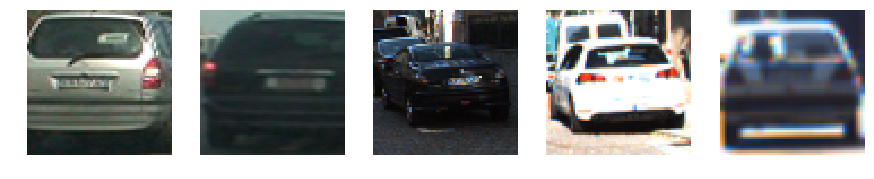

In [3]:
f,ax = plt.subplots(1,5,figsize=(15,15))

for i in range(5):
    r = random.randint(0, len(car_images))
    image = cv2.imread(car_images[r])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].set_axis_off()
    ax[i].imshow(image)  

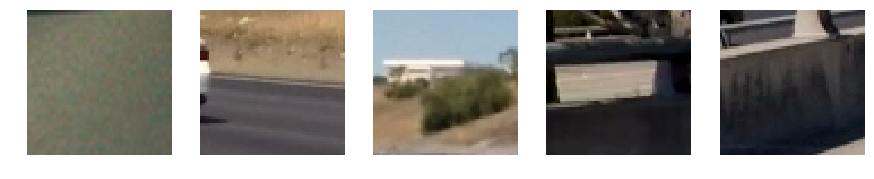

In [4]:
f,ax = plt.subplots(1,5,figsize=(15,15))

for i in range(5):
    r = random.randint(0, len(non_car_images))
    image = cv2.imread(non_car_images[r])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].set_axis_off()
    ax[i].imshow(image)  

### Explore Color Spaces

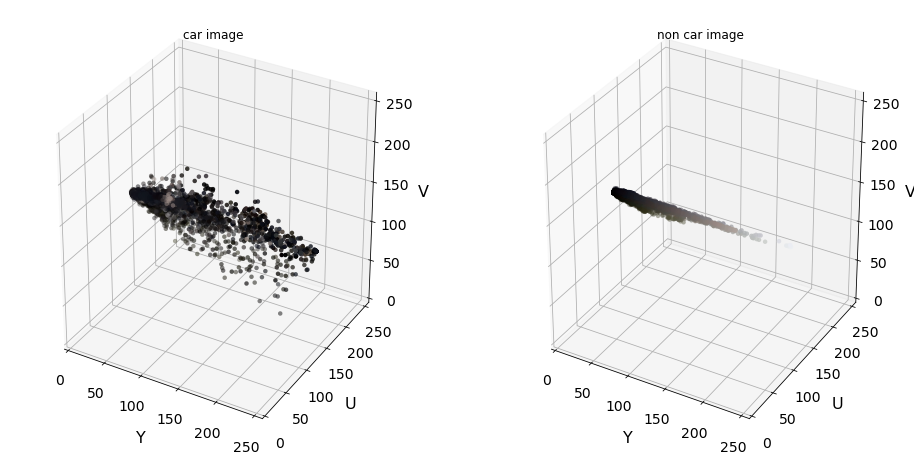

In [5]:
'''
Function to do a 3d plot of images in the different color spaces
'''
def plot3d(pixels, colors_rgb, ax,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    #ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


'''
Convert a random car image to different color spaces
'''
# Read a car image
r = random.randint(0, len(car_images))
car_image = cv2.imread(car_images[r])
    
# Select a small fraction of pixels to plot by subsampling it
scale = max(car_image.shape[0], car_image.shape[1], 64) / 64  # at most 64 rows and columns
car_image_small = cv2.resize(car_image, (np.int(car_image.shape[1] / scale), np.int(car_image.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
car_image_small_RGB = cv2.cvtColor(car_image_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
car_image_small_HSV = cv2.cvtColor(car_image_small, cv2.COLOR_BGR2HSV)
car_image_small_HLS = cv2.cvtColor(car_image_small, cv2.COLOR_BGR2HLS)
car_image_small_LUV = cv2.cvtColor(car_image_small, cv2.COLOR_BGR2LUV)
car_image_small_YUV = cv2.cvtColor(car_image_small, cv2.COLOR_BGR2YUV)
car_image_small_rgb = car_image_small_RGB / 255.  # scaled to [0, 1], only for plotting

'''
Convert a random non car image to different color spaces
'''
# Read a non car  image
r = random.randint(0, len(non_car_images))
non_car_image = cv2.imread(non_car_images[r])
    
# Select a small fraction of pixels to plot by subsampling it
scale = max(non_car_image.shape[0], non_car_image.shape[1], 64) / 64  # at most 64 rows and columns
non_car_image_small = cv2.resize(non_car_image, (np.int(non_car_image.shape[1] / scale), np.int(non_car_image.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
non_car_image_small_RGB = cv2.cvtColor(non_car_image_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
non_car_image_small_HSV = cv2.cvtColor(non_car_image_small, cv2.COLOR_BGR2HSV)
non_car_image_small_HLS = cv2.cvtColor(non_car_image_small, cv2.COLOR_BGR2HLS)
non_car_image_small_LUV = cv2.cvtColor(non_car_image_small, cv2.COLOR_BGR2LUV)
non_car_image_small_YUV = cv2.cvtColor(non_car_image_small, cv2.COLOR_BGR2YUV)
non_car_image_small_rgb = non_car_image_small_RGB / 255.  # scaled to [0, 1], only for plotting

'''
Show the side by side images of the car and non car images in a certain color space
'''
# Plot and show the car and non car image side by side
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax1 = plot3d(car_image_small_YUV, non_car_image_small_rgb, ax, axis_labels=list("YUV"))
ax1.set_title('car image')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax2 = plot3d(non_car_image_small_YUV, non_car_image_small_rgb, ax, axis_labels=list("YUV"))
ax2.set_title('non car image')

plt.show()

## Explore HOG Features

In [6]:
from skimage.feature import hog
'''
Define a function to return HOG features and visualization
 '''
# def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
#     if vis == True:
#         # Use skimage.hog() to get both features and a visualization
#         features, hog_image = hog(image=img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                         cells_per_block=(cell_per_block, cell_per_block), visualise=True,feature_vector=False, block_norm='L2-Hys')
#         return features, hog_image
#     else:      
#         # Use skimage.hog() to get features only
#         features, hog_image = hog(image=img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
#                         cells_per_block=(cell_per_block, cell_per_block), visualise=False,feature_vector=feature_vec, block_norm='L2-Hys')
#         return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

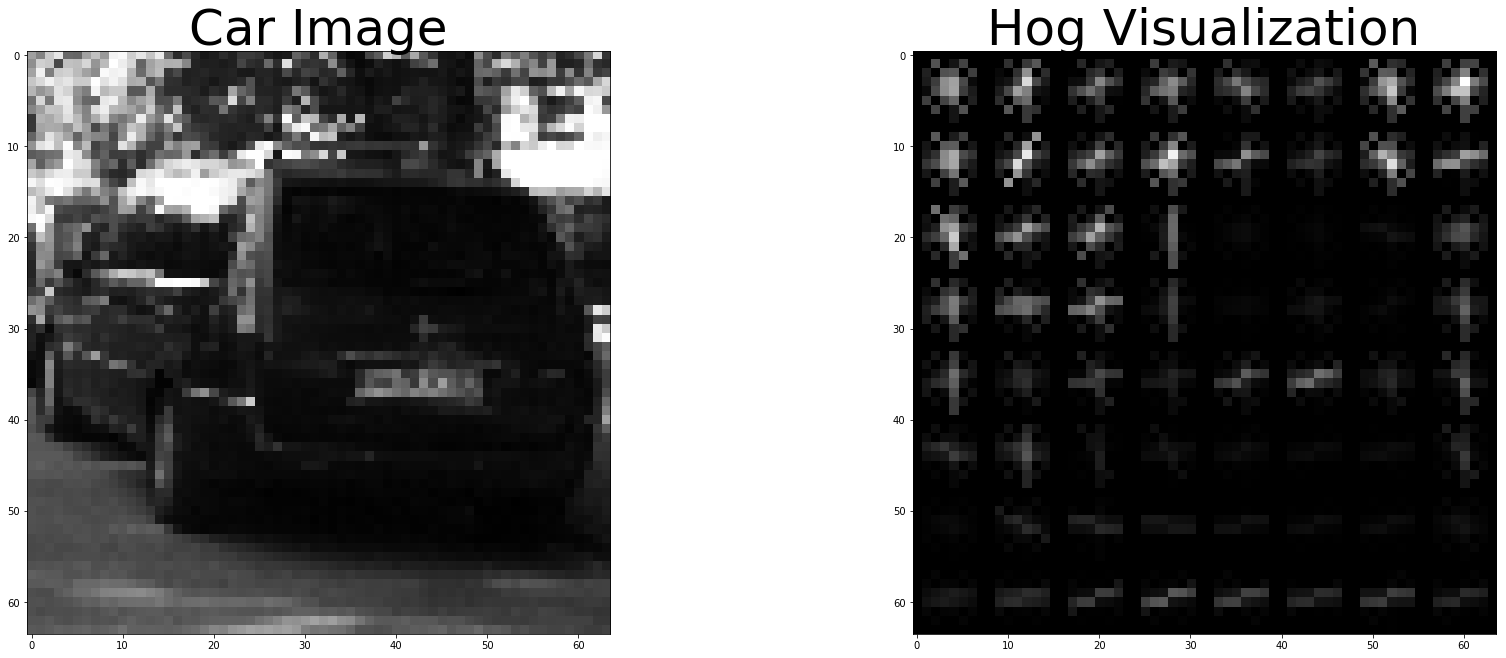

In [7]:
# Read a car image
r = random.randint(0, len(car_images))
car_image = cv2.imread(car_images[r])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

'''
Plot the result
'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(car_gray, cmap='gray')
ax1.set_title('Car Image', fontsize=50)
ax2.imshow(hog_image, cmap = 'gray')
ax2.set_title('Hog Visualization', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

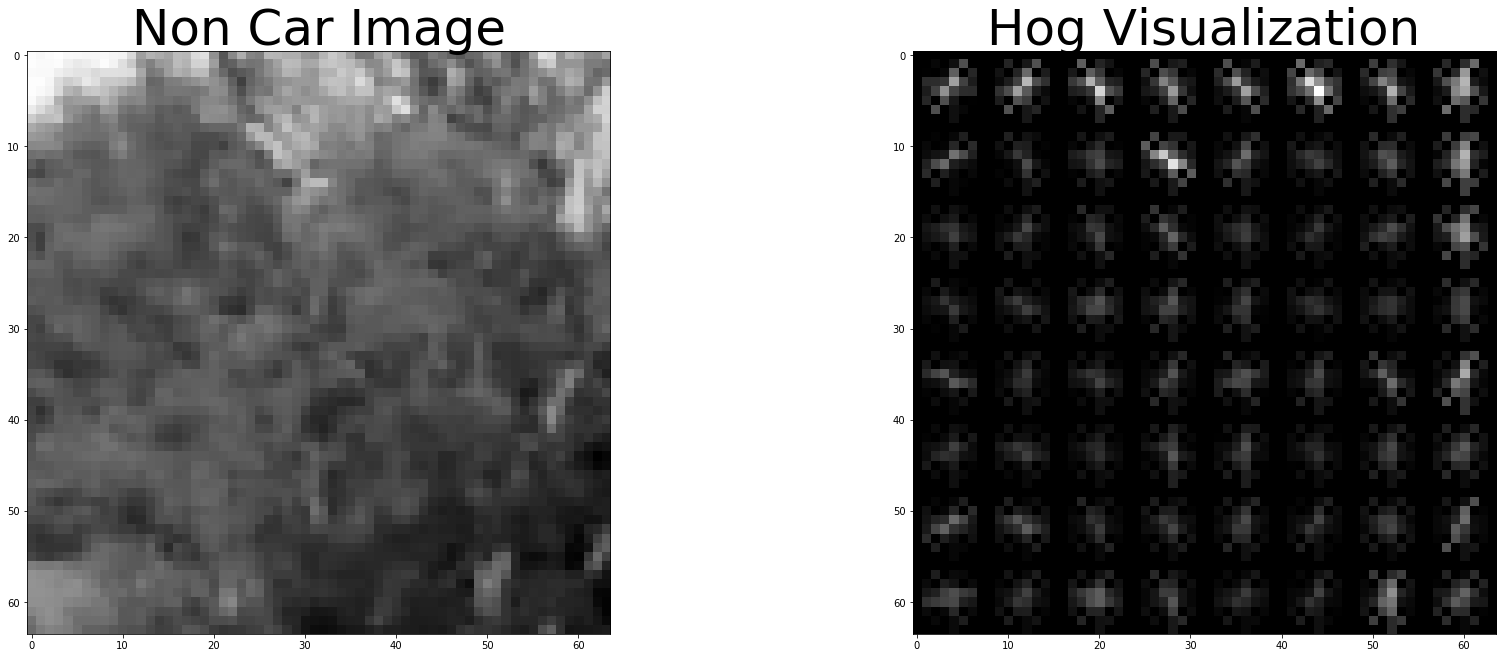

In [8]:
# Read a non car image
r = random.randint(0, len(non_car_images))
non_car_image = cv2.imread(non_car_images[r])
non_car_gray = cv2.cvtColor(non_car_image, cv2.COLOR_BGR2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(non_car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

'''
Plot the result
'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(non_car_gray, cmap='gray')
ax1.set_title('Non Car Image', fontsize=50)
ax2.imshow(hog_image, cmap = 'gray')
ax2.set_title('Hog Visualization', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Combine Color and HOG Features

In [9]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def extract_image_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features_from_all_images(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_features = []
        # Read in each one by one
        img = mpimg.imread (file)
        #img = cv2.imread(file)
        #img = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)

        img_features= extract_image_features(img, color_space, spatial_size,
                        hist_bins, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)

        features.append (img_features)
    # Return list of feature vectors
    return features

### Feature extraction parameters

In [ ]:
# Feature extraction parameters
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [ ]:
t=time.time()

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = car_images[0:sample_size]
#non_cars = non_car_images[0:sample_size]
cars = car_images
non_cars = non_car_images

car_features = extract_features_from_all_images(cars, color_space=color_space, 
                                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                                 orient=orient, pix_per_cell=pix_per_cell, 
                                                 cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                                 spatial_feat=spatial_feat, 
                                                 hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features[0]))

non_car_features = extract_features_from_all_images(non_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

print(len(non_car_features[0]))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

car_ind = np.random.randint(0, len(cars))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()


### Train a SVM Classifier

In [ ]:
from sklearn.model_selection import train_test_split

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
#svc = LinearSVC()
svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
# Store away the model parameters
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["color_space"]= color_space
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"]= spatial_size
dist_pickle["hist_bins"]=hist_bins
index = 11
filename = "svm_rbf_model_parameters_spatial_hist"+str(index)+"_"+color_space+"_orient_"+str(orient)+ \
"_pix_per_cell_"+str(pix_per_cell)+"_cell_per_block_" + str(cell_per_block)+".p"
pickle.dump( dist_pickle, open(filename, "wb" ))
print("Stored parameters in ", filename)

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_in_image(img, color_space, hog_channel, ystart, ystop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step = 2, get_all_boxes=False):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    
    #Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img)      
 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch[:,:,0].shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch[:,:,0].shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image    
    if hog_channel == "ALL":
        hog1 = get_hog_features(ctrans_tosearch[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ctrans_tosearch[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ctrans_tosearch[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # initialize array of boxes to return all the boxes where cars are detected
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == "ALL":
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #test_features = X_scaler.transform(np.hstack(hog_features).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            if (test_prediction == 1) or get_all_boxes:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return boxes

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

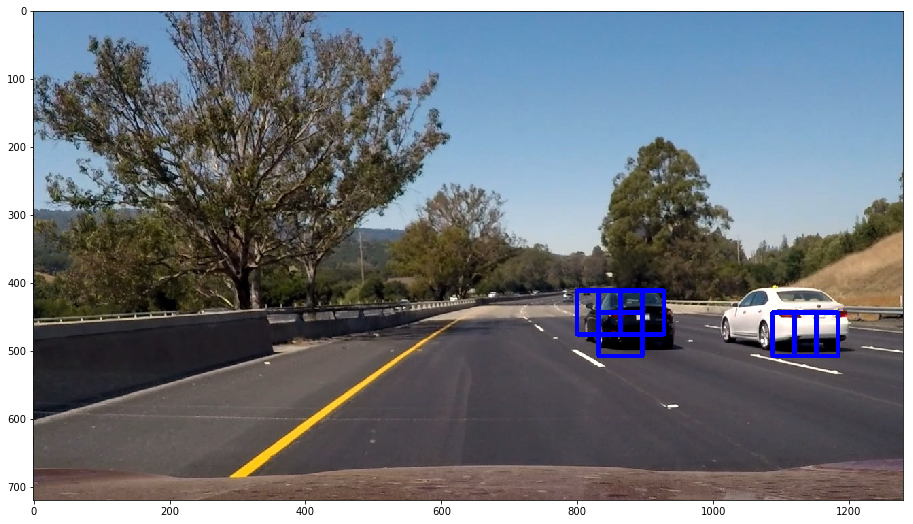

In [19]:
test_img = mpimg.imread('./test_images/test6.jpg')

dist_pickle = pickle.load( open('svm_model/svm_rbf_model_parameters_spatial_hist_20_YUV_orient_9_pix_per_cell_16_cell_per_block_2.p', "rb" ) )
svc = dist_pickle["svc"]
color_space = dist_pickle["color_space"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

ystart = 380
ystop = 656
scale = 1.0

boxes = find_cars_in_image(test_img, color_space, hog_channel, ystart, ystop, scale, svc, X_scaler, 
                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


# Draw boxes on the image
fig = plt.figure(figsize=(24,9))
out_img = draw_boxes(test_img, boxes)
plt.imshow(out_img)

## Multiscale windows

Play around with different Ystart and Ystop and different scales for the windows

Length of Boxes Scale 1.1: 62
Length of Boxes Scale 1.5: 48
Length of Boxes2: 18
Length of Boxes3: 44


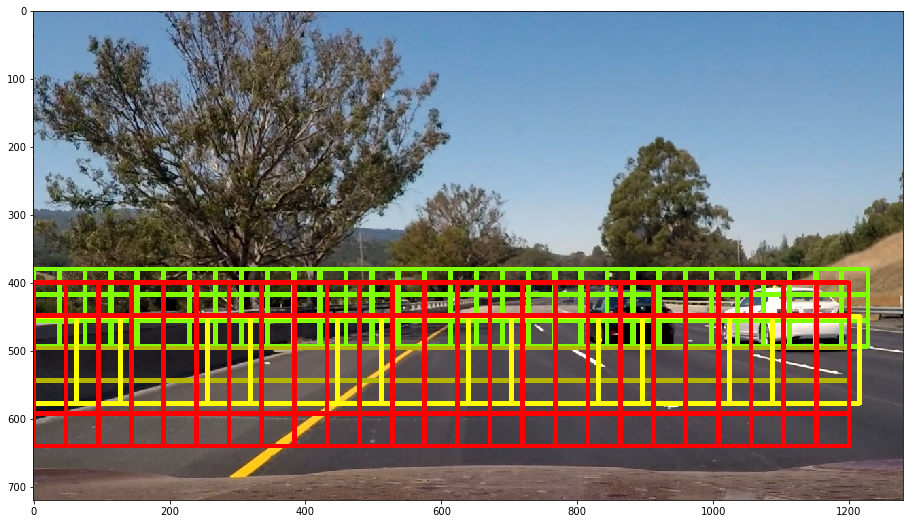

In [33]:
all_boxes=[]
# Scale 1.1
# ystart1 = 400
# ystop1 = 520
# scale1 = 1.0
# hc = "ALL" # Can be 0, 1, 2, or "ALL" 
# boxes1 = find_cars_in_image(test_img, cs, hc, ystart1, ystop1, scale1, svc, xscaler, 
#                            o, ppc, cpb, ss, hb, get_all_boxes=)
# print("Length of Boxes Scale 1.0:", len(boxes1))
# all_boxes.extend(boxes1)

# Scale 1.1
ystart1_1 = 380
ystop1_1 = 560
scale1_1 = 1.2
boxes1_1 = find_cars_in_image(test_img, color_space, hog_channel, ystart1_1, ystop1_1, scale1_1, svc, X_scaler, 
                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, get_all_boxes=True)
print("Length of Boxes Scale 1.1:", len(boxes1_1))
all_boxes.extend(boxes1_1)

# Scale 1.5
ystart1_5 = 400
ystop1_5 = 620
scale1_5 = 1.5
boxes1_5 = find_cars_in_image(test_img, color_space, hog_channel, ystart1_5, ystop1_5, scale1_5, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, get_all_boxes=True)
print("Length of Boxes Scale 1.5:", len(boxes1_5))
all_boxes.extend(boxes1_5)

# Scale 1.9
ystart2 = 450
ystop2 = 650
scale2 = 2.0
boxes2 = find_cars_in_image(test_img, color_space, hog_channel, ystart2, ystop2, scale2, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, get_all_boxes=True)
print("Length of Boxes2:", len(boxes2))
all_boxes.extend(boxes2)

# Window around cars that are in the middle (neither too close nor too far)
ystart3 = 400
ystop3 = 700
scale3 = 3.0
boxes3 = find_cars_in_image(test_img, color_space, hog_channel, ystart3, ystop3, scale3, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step = 1, get_all_boxes=True)
print("Length of Boxes3:", len(boxes3))
all_boxes.extend(boxes3)

# Draw boxes on the image
fig = plt.figure(figsize=(24,9))
#out_img = draw_boxes(test_img, boxes1, color=(0, 160, 0))
out_img = draw_boxes(test_img, boxes1_1, color=(128, 255, 0))
out_img = draw_boxes(out_img, boxes1_5, color=(180, 180, 0))
out_img = draw_boxes(out_img, boxes2, color=(255, 255, 0))
out_img = draw_boxes(out_img, boxes3, color=(255, 0, 0))
#out_img = draw_boxes(scale_test_img, all_boxes, color=(0, 0, 255))
plt.imshow(out_img)

## Handling multiple detections and False positives

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

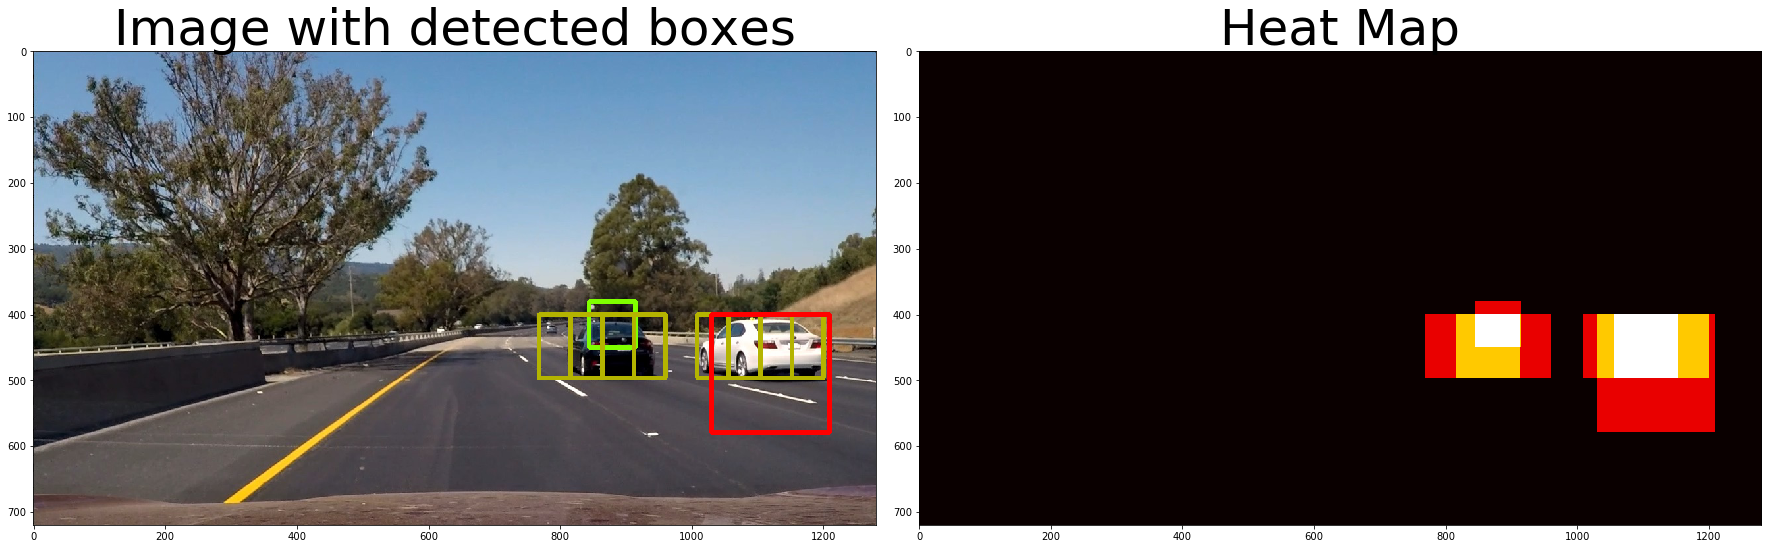

In [23]:
# Read in image similar to one shown above 
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,all_boxes)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Image with detected boxes', fontsize=50)
ax2.imshow(heat, cmap = 'hot')
ax2.set_title('Heat Map', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

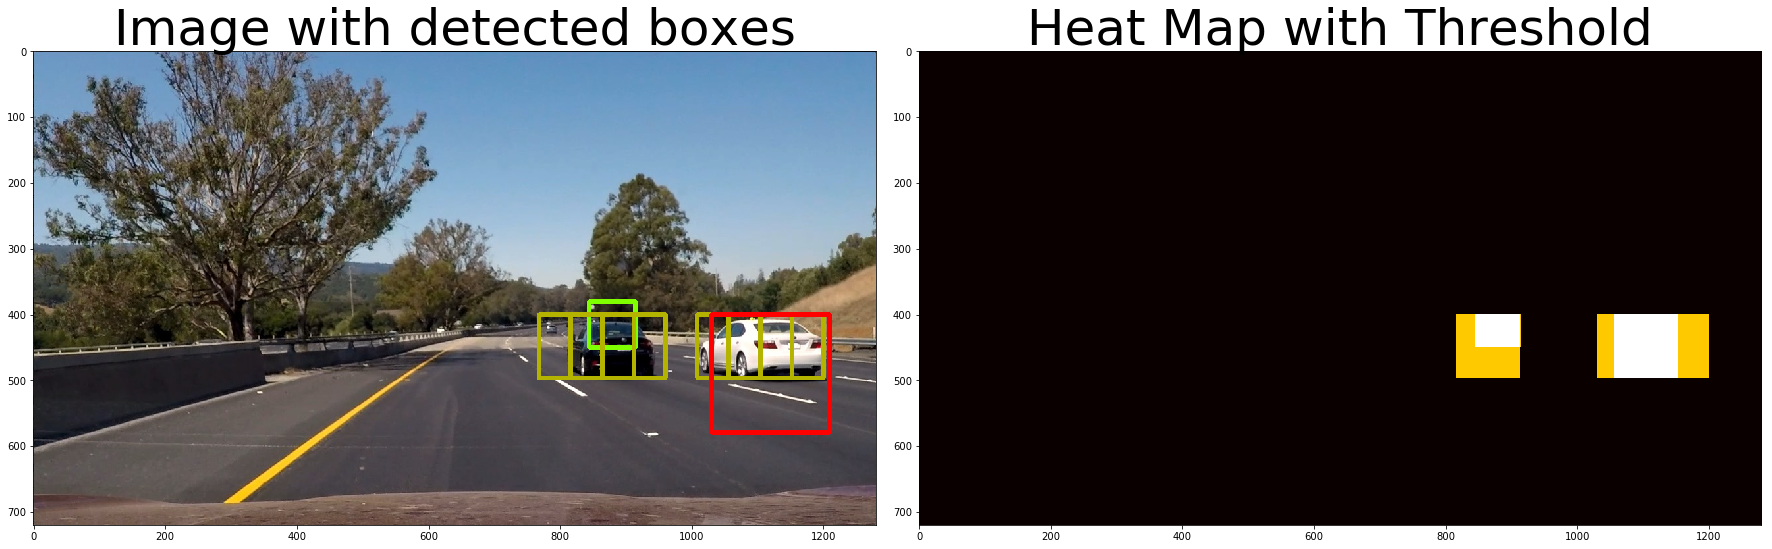

In [24]:
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Image with detected boxes', fontsize=50)
ax2.imshow(heatmap, cmap = 'hot')
ax2.set_title('Heat Map with Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

2 cars found


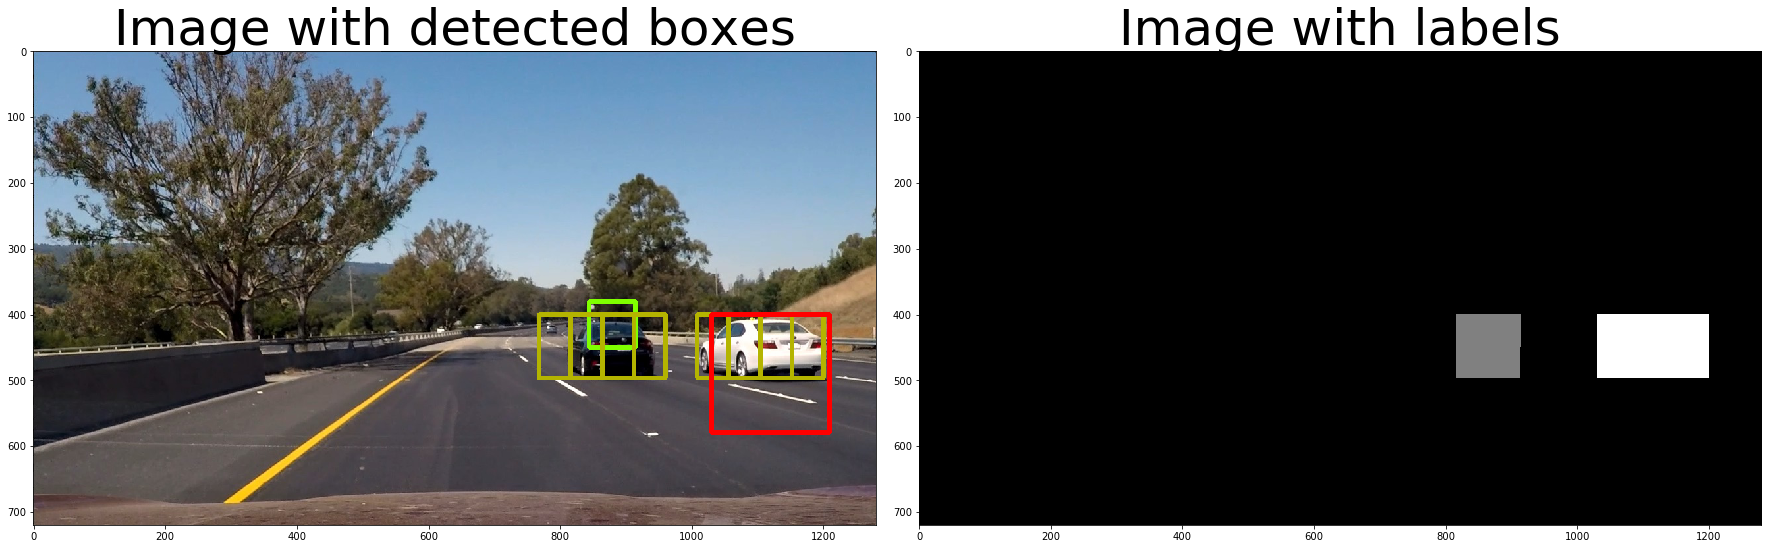

In [25]:
labels = label(heatmap)
print(labels[1], 'cars found')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Image with detected boxes', fontsize=50)
ax2.imshow(labels[0], cmap = 'gray')
ax2.set_title('Image with labels', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

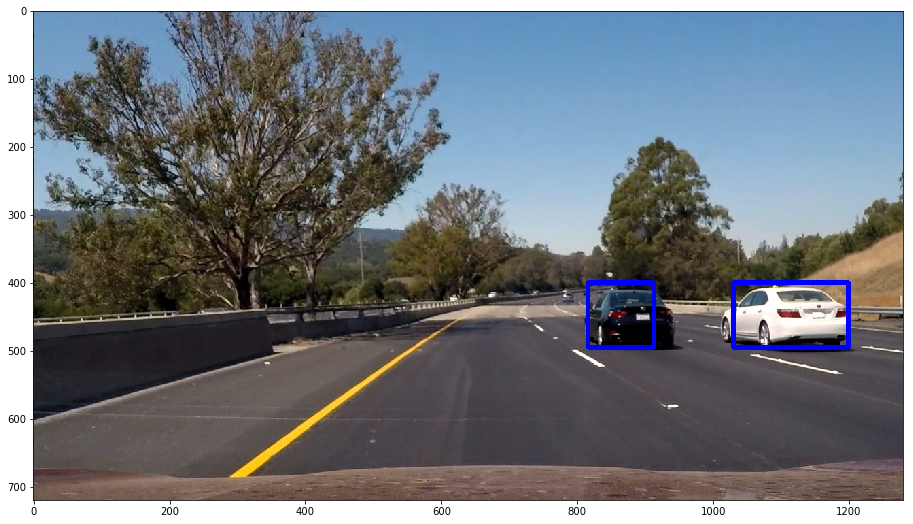

In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
fig = plt.figure(figsize=(24,9))
plt.imshow(draw_img)

## Vehicle Detection Pipeline

Put all the pieces together in a vehicle detection pipeline

In [27]:
class VehicleDetector():
    def __init__(self):
        self.heatmaps = deque(maxlen=10)
    

    def vehicle_detection_pipeline(self, image):
        # initialize current boxes to empty list
        current_boxes=[]
    
        # Scale 1.1
        ystart1_1 = 380
        ystop1_1 = 560
        scale1_1 = 1.1
        boxes1_1 = find_cars_in_image(image, color_space, hog_channel, ystart1_1, ystop1_1, scale1_1, svc, X_scaler, 
                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, get_all_boxes=False)
        current_boxes.extend(boxes1_1)

        # Scale 1.5
        ystart1_5 = 400
        ystop1_5 = 650
        scale1_5 = 1.5
        boxes1_5 = find_cars_in_image(image, color_space, hog_channel, ystart1_5, ystop1_5, scale1_5, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, get_all_boxes=False)
        current_boxes.extend(boxes1_5)

        # Scale 2.0
        ystart2 = 400
        ystop2 = 650
        scale2 = 1.9
        boxes2 = find_cars_in_image(image, color_space, hog_channel, ystart2, ystop2, scale2, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, get_all_boxes=False)
        current_boxes.extend(boxes2)

        # Scale 3.0
        ystart3 = 400
        ystop3 = 700
        scale3 = 2.8
        boxes3 = find_cars_in_image(image, color_space, hog_channel, ystart3, ystop3, scale3, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step = 1, get_all_boxes=False)
        current_boxes.extend(boxes3)
    
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,current_boxes)
    
        # Visualize the heatmap when displaying    
        heat = np.clip(heat, 0, 255)
        # Store the current heatmaps into the list of heatmaps
        self.heatmaps.append(heat)
        # Compute the sum of store heatmaps
        heatmap_sum = sum(self.heatmaps)
        
        # Apply threshold to help remove false positives
        average_heatmap = apply_threshold(heatmap_sum,1+len(self.heatmaps)//2)
        
        # Apply labels to the heatmap using label() function from scipy.ndimage.measurements
        labels = label(average_heatmap)
        number_of_cars_found = labels[1]
    
        # Draw labeled boxes
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
        return draw_img


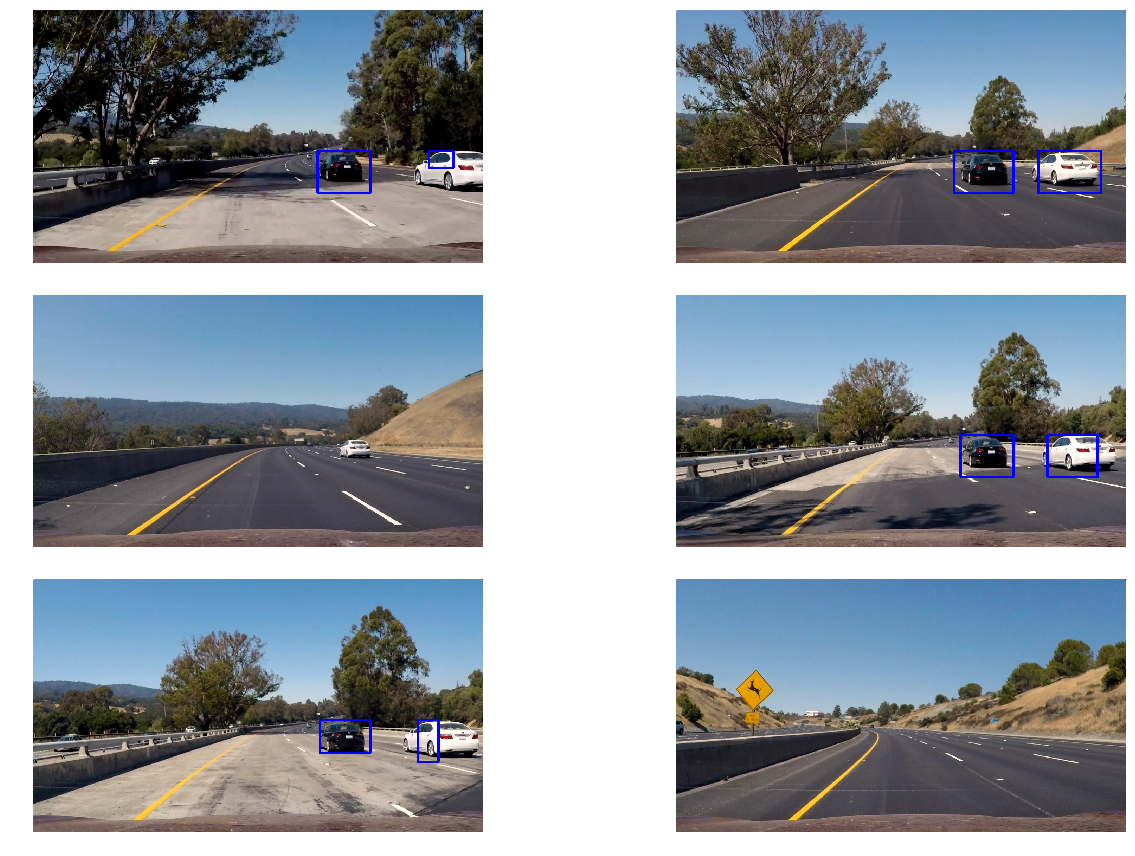

In [34]:
dist_pickle = pickle.load( open('svm_model/svm_rbf_model_parameters_spatial_hist_20_YUV_orient_9_pix_per_cell_16_cell_per_block_2.p', "rb" ) )
svc = dist_pickle["svc"]
color_space = dist_pickle["color_space"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

test_images = glob.glob('./test_images/test*.jpg')
f,ax = plt.subplots(3,2,figsize=(18,12))
ax = ax.ravel()
f.tight_layout()

for i, img in enumerate(test_images):
    vd = VehicleDetector()
    output_img = vd.vehicle_detection_pipeline(mpimg.imread(img))
    ax[i].imshow(output_img)
    ax[i].set_axis_off()
    

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
test_video_output = 'video_output/test_video_out5.mp4'
vd = VehicleDetector()
    
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(vd.vehicle_detection_pipeline) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video video_output/test_video_out5.mp4
[MoviePy] Writing video video_output/test_video_out5.mp4


 97%|█████████▋| 38/39 [00:46<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/test_video_out5.mp4 

CPU times: user 4min 15s, sys: 1.23 s, total: 4min 16s
Wall time: 47.4 s


In [ ]:
project_video_output = 'video_output/project_video_out3.mp4'
vd = VehicleDetector()
    
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(vd.vehicle_detection_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video video_output/project_video_out3.mp4
[MoviePy] Writing video video_output/project_video_out3.mp4


 52%|█████▏    | 658/1261 [13:48<12:35,  1.25s/it]